# Camembert-base fine-tuned models' results

Compilation of finetuned models' results on the Camembert-base model. Fine-tuning was done with the same dataset *esg_fr_classification*.
<br/>

---
### Table of Contents
1. [Simple Model 1](#model1)
2. [Model 2: Input sequence length increase](#model2)

---

In [30]:
import pandas as pd
import torch
import torch.nn as nn
import utilsNb as utils
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers.modeling_outputs import TokenClassifierOutput
from sklearn.metrics import classification_report


# reload
%load_ext autoreload
%autoreload 2

ID_TO_LABEL = {
    0: 'non-esg',
    1: 'environnemental',
    2: 'social',
    3: 'gouvernance'
}

DATASET_PATH = '../data/final_test_esg.csv'

def load_sd_model(state_dict_path, model_class, checkpoint, num_labels, id2label):
    model = model_class(checkpoint=checkpoint, num_labels=num_labels, id2label=id2label)
    model.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))
    model.eval()
    print('\nModel loaded for evaluation')
    return model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
CHECKPOINT = 'camembert-base'
NUM_LABELS = len(ID_TO_LABEL)
LABEL_TO_ID = {v: k for k, v in ID_TO_LABEL.items()}
TOKENIZER = AutoTokenizer.from_pretrained('camembert-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(DATASET_PATH)
df2 = pd.read_csv('../data/final_test_esg_clean.csv')


## Model 1: Basic fine-tuning with dataset 
<a id="model1"></a>

In [32]:
class ModelTorch1(nn.Module):
  def __init__(self,checkpoint,num_labels,id2label): 
    super(ModelTorch1,self).__init__() 
    self.num_labels = num_labels 
    self.id2label = id2label

    #Load Model with given checkpoint and extract its body
    self.model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [33]:
model_path ='../models/torch_models/state_dicts/torchmodel1.pt'

model = load_sd_model(model_path, ModelTorch1, CHECKPOINT, NUM_LABELS, ID_TO_LABEL)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model loaded for evaluation


In [34]:
df_res = utils.predict_df(model, TOKENIZER, df2, device)
df_res.to_csv('../data/torch_model_predictions.csv')

52it [00:04, 10.80it/s]


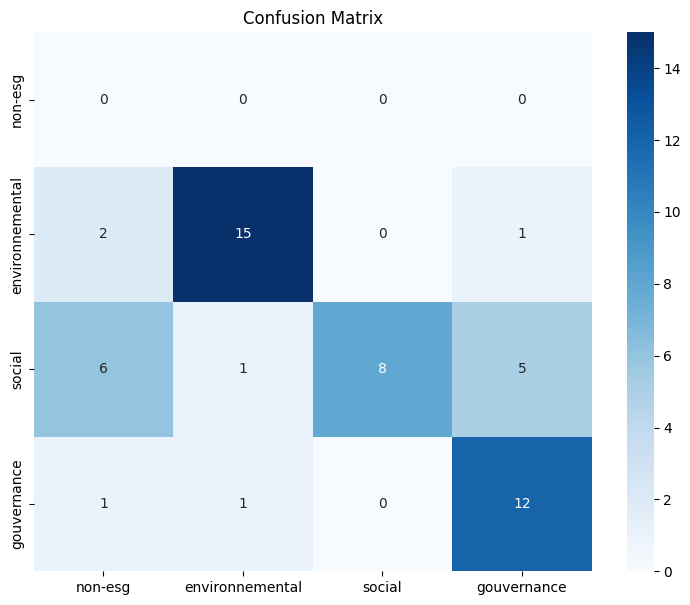

In [35]:
utils.plot_confusion_matrix(df_res['esg_category'], df_res['predicted_class'], list(ID_TO_LABEL.values()))

In [11]:
# classification report
report = classification_report(df_res['esg_category'], df_res['predicted_class'], zero_division=0)
print(report)

                 precision    recall  f1-score   support

environnemental       0.84      0.84      0.84        19
    gouvernance       0.64      0.89      0.74        18
        non-esg       0.00      0.00      0.00         0
         social       1.00      0.39      0.56        28

       accuracy                           0.66        65
      macro avg       0.62      0.53      0.54        65
   weighted avg       0.85      0.66      0.70        65



## Model 2: Input sequence length increase
<a id="model2"></a>

In [8]:
class cb_model_long(nn.Module):
  def __init__(self,checkpoint,num_labels, id2label, max_length = 512): 
    super(cb_model_long,self).__init__() 
    self.num_labels = num_labels 
    self.id2label = id2label

    #Load Model with given checkpoint and extract its body
    self.model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights
    
    self.model.config.max_position_embeddings = max_length
    self.model.base_model.embeddings.position_ids = torch.arange(max_length).expand((1, -1)).to(torch.long)
    self.model.base_model.embeddings.token_type_ids = torch.zeros(max_length).expand((1, -1)).to(torch.long)  
    
    orig_pos_emb = self.model.base_model.embeddings.position_embeddings.weight
    self.model.base_model.embeddings.position_embeddings.weight = torch.nn.Parameter(torch.cat((orig_pos_emb, orig_pos_emb)))

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [9]:
sd_path ='../models/camembert-long-model-1/models/state_dict/camembert_long_state_dict.pt'
model = cb_model_long(checkpoint=CHECKPOINT, num_labels=NUM_LABELS, id2label=ID_TO_LABEL, max_length=1024)
model.load_state_dict(torch.load(sd_path, map_location=torch.device('cpu')))
model.eval()
print('\nModel loaded for evaluation')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model loaded for evaluation


In [29]:
df_res = utils.predict_df(model, TOKENIZER, df2, device)
df_res.to_csv('../data/cb_long_model_predictions.csv',encoding='utf8')

52it [00:04, 10.88it/s]


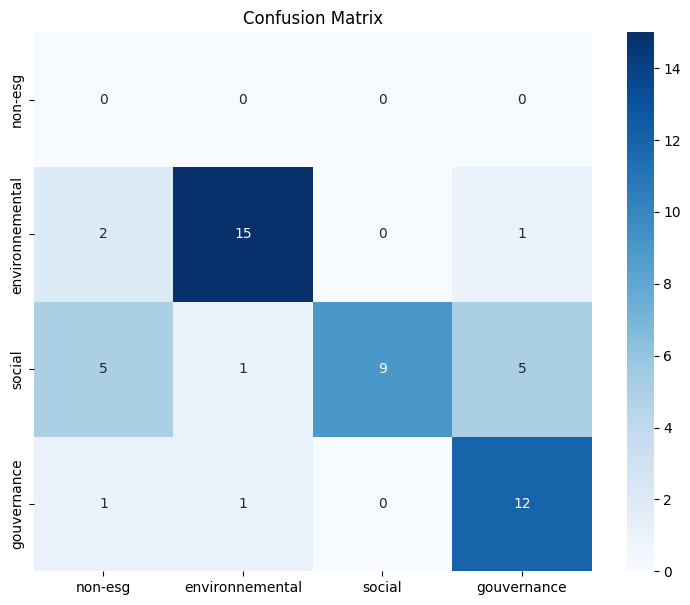

In [12]:
utils.plot_confusion_matrix(df_res['esg_category'], df_res['predicted_class'], list(ID_TO_LABEL.values()))

In [15]:
# classification report
report = classification_report(df_res['esg_category'], df_res['predicted_class'], zero_division=0)
print(report)

                 precision    recall  f1-score   support

environnemental       0.88      0.83      0.86        18
    gouvernance       0.67      0.86      0.75        14
        non-esg       0.00      0.00      0.00         0
         social       1.00      0.45      0.62        20

       accuracy                           0.69        52
      macro avg       0.64      0.54      0.56        52
   weighted avg       0.87      0.69      0.74        52

